In [59]:
##Version 1 du modèle d'évolution, pour un modèle plus abouti, voir 'evolution_v2.ipynb'
 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from math import comb
from tqdm import tqdm


In [60]:
## Paramètres généraux

n_taux_stat = 36
n_taux_excep = 11
n_revalo_IM = 10

N = n_taux_stat * n_taux_excep * n_revalo_IM

print("Nombre d'états possibles : {}\n".format(N))

Taux_stat = np.linspace(10,45, n_taux_stat)
Taux_excep = np.linspace(0,10,n_taux_excep)
revalo_IM = [0] + list(np.linspace(2,6, n_revalo_IM -1))
p3_anc = list(np.array([1, 0.95, 0.9, 0.85, 0.75, 0.6, 0.4])) # Probabilité de n'avoir aucune revalorisation de l'indice majoré en fonction de l'ancienneté.
p2_anc =[0.65, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3] #probabilité de n'avoir aucune prime exceptionnelle en fonction de l'ancienneté

print('Part de prime "statutaire" dans le salaire brut : {}\n'.format(Taux_stat))
print('Part de prime "exceptionnelle" dans le salaire brut : {}\n'.format(Taux_excep))
print("Revalorisation de l'indice majoré : {}".format(revalo_IM))


Nombre d'états possibles : 3960

Part de prime "statutaire" dans le salaire brut : [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]

Part de prime "exceptionnelle" dans le salaire brut : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

Revalorisation de l'indice majoré : [0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]


In [61]:
def conv(X):
    '''Entrée : X: ndarray de shape (8,)
                avec comme composante : - Fonction publique (Etat, téritoriale, hspitalière)
                                        - Catégorie (A, B, C)
                                        - Indice brut majoré (IM)
                                        - congé maladie (0) ou pas de congé maladie (1)
                                        - âge
                                        - nombre d'enfants à charge
                                        - zone géographique
                                        - Nouvelle bonification indicière (NBI)
        Sortie : X1: ndarray de shape (6,)
                avec comme composantes : - ancienneté 
                                        - maladie
                                        - indice brut majoré (IM)
                                        - revalorisation IM précédente
                                        - taux de prime statutaire (enfants, zone géographique, NBI)
                                        - taux de prime exceptionnelle (heures supplémentaires, RIFSEEP, GIPA... ?) '''
    FP, cat, IM, maladie, age, nbr_enf, zone_geo, NBI = X[0], X[1],X[2],X[3],X[4],X[5],X[6],X[7]
    Y=np.zeros((6,))
    Y[2] = IM
    Y[1] = maladie
    t_stat = (NBI/IM)*100 + 3*(zone_geo==1) + 1*(zone_geo==2) + 3*(nbr_enf==2) + 8*(nbr_enf==3) + 6*nbr_enf*(nbr_enf > 3)
    t_excep = np.random.binomial(10,0.1)
    anc = np.random.randint(0,7)
    Y[0] = anc
    Y[3] = np.random.choice(revalo_IM)
    Y[4] = t_stat
    Y[5] = t_excep

    return Y

    
        

In [62]:
def list_geom(p, n):
    '''Renvoie une liste de taille n+1 avec les n premières valeurs de la fonction de masse (P(X=i)) 
    de la loi géométrique de paramètre p et donne la probabilité restante (1-sum(n primères proba)) en position n+1
    
    Forme du résultat : [P(X=1), P(X=2), ...., P(X=n), 1 - (P(X=1) + P(X=2) + ... + P(X=n))]'''

    q = 1-p
    L = []
    for i in range(n):
        L.append(p*(q**i))
    # L.append(0)
    L=np.array(L)
    #L[n] = 1-np.sum(L)
    L[0] += 1-np.sum(L)
    return L

def list_binom(p,n, eps = 1e-30):
    '''Renvoie une liste de taille n+1 avec les n valeurs de la fonction de masse (P(X=i)) 
    de la loi binomiale de paramètre (n, p)
    
    Forme du résultat : [P(X=1), P(X=2), ...., P(X=n)]'''
    n-=1
    q = 1-p
    L=[]
    res=0
    for i in range(n+1):
        a = comb(n, i)*(p**i)*(q**(n-i))
        if a>eps:
            L.append(comb(n, i)*(p**i)*(q**(n-i)))
        else :
            L.append(a)
            res+=0
    L=np.array(L)
    i = np.argmax(L)
    L[i]+=res
    return L

1.0
[6.00104858e-01 2.40000000e-01 9.60000000e-02 3.84000000e-02
 1.53600000e-02 6.14400000e-03 2.45760000e-03 9.83040000e-04
 3.93216000e-04 1.57286400e-04]


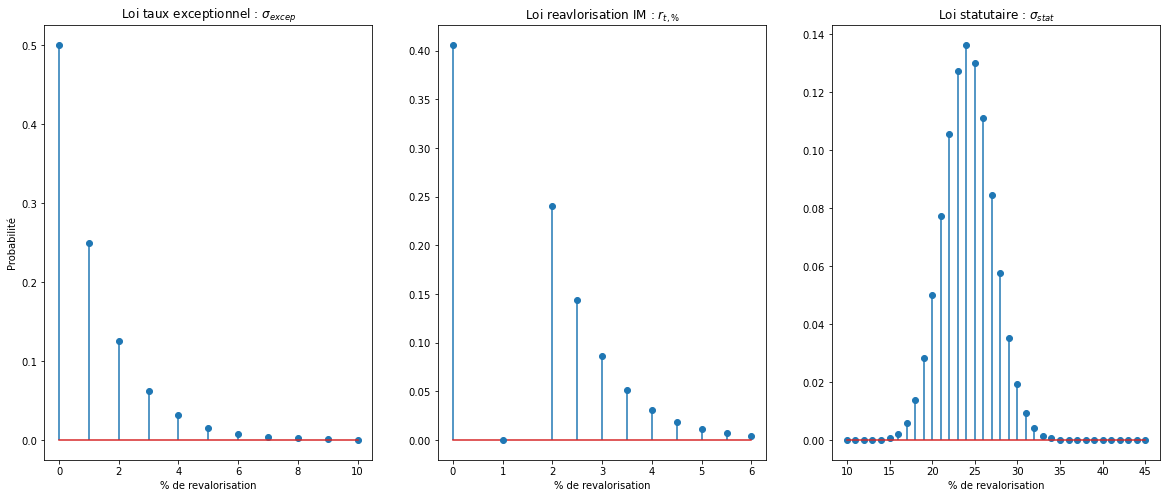

In [74]:
plt.figure(figsize=(20,8));

plt.subplot(1,3,1);
plt.stem(Taux_excep, list_geom(0.5, n_taux_excep), use_line_collection=True)
plt.ylabel('Probabilité')
plt.xlabel('% de revalorisation')
plt.title("Loi taux exceptionnel : $\sigma_{excep}$");
plt.subplot(1,3,2);
plt.stem(revalo_IM, list_geom(0.4, n_revalo_IM), use_line_collection=True)
plt.stem([1],[0], use_line_collection=True)
plt.xlabel('% de revalorisation')
plt.title("Loi reavlorisation IM : $r_{t,\%}$");
plt.subplot(1,3,3);
plt.stem(Taux_stat, list_binom(15/37, n_taux_stat), use_line_collection=True)
plt.xlabel('% de revalorisation')
plt.title("Loi statutaire : $\sigma_{stat}$");

print(list_binom(35/37, n_taux_stat).sum())
print(list_geom(0.6, n_revalo_IM))



In [64]:
def indice(i,j,k, n_taux_stat = n_taux_stat, n_taux_excep = n_taux_excep , n_revalo_IM = n_revalo_IM):
    return i*n_taux_excep*n_revalo_IM+j*n_revalo_IM+k

def matrice_markov(p2,p3,anc, n_taux_stat = n_taux_stat, n_taux_excep = n_taux_excep, n_revalo_IM = n_revalo_IM):
    '''Renvoie la matrice des probabilités de Markov du problème (à détailler) '''

    n_lignes = n_taux_stat * n_taux_excep * n_revalo_IM
    P = np.zeros((n_revalo_IM*n_taux_excep*n_taux_stat, n_revalo_IM*n_taux_excep*n_taux_stat))
    for i in range(n_taux_stat):
        L_stat = list_binom(min((i+4)/(n_taux_stat+1),(n_taux_stat-1)/(n_taux_stat+1)),n_taux_stat) #Ajustement pour ne pas reculer trop reculer de taux statutaire en fin de carière.
        for j in range(n_taux_excep):
            L_excep = list_geom(p2[anc], n_taux_excep)
            for k in range(n_revalo_IM):
                L_revalo = list_geom(p3[anc], n_revalo_IM)
                for i2 in range(n_taux_stat):
                    for j2 in range(n_taux_excep):
                        for k2 in range(n_revalo_IM):
                            coeff = L_stat[i2]*L_excep[j2]*L_revalo[k2]
                            ligne = indice(i,j,k)
                            colonne = indice(i2,j2,k2)
                            P[ligne, colonne] = coeff
    return P

In [65]:
# Matrice des probabilités markoviennes
P = []
for l in tqdm(range(7)):
    P.append(matrice_markov(p2_anc, p3_anc, l,))

100%|██████████| 7/7 [02:39<00:00, 22.82s/it]


In [66]:
[p.shape for p in P]

[(3960, 3960),
 (3960, 3960),
 (3960, 3960),
 (3960, 3960),
 (3960, 3960),
 (3960, 3960),
 (3960, 3960)]

In [67]:
## Vérification de la propriété de matrice stochastique 

Verif = []
for p in P:
    I = np.zeros((N,))
    for l in range(N):
        I[l] = p[l,:].sum()
    Verif.append((I>0.99999).all())

print('Matrice stochastique ? : {}'.format(np.array(Verif).all()))




Matrice stochastique ? : True


In [68]:
def tirage_al(list):
    '''list : liste/array dont les éléments somment à 1,
     représente une distribution de probabilité où la probabilité d'obtenir la classe de l'index i est l'élément L[i]
     
     La fonction renvoie un indexe, tiré au hasard en siuvant la distribution décrite par list'''

    n = len(list)
    s = np.cumsum(np.array(list)) #réalise la somme cumulée des coefficients de list
    nbr = np.random.random()
    l=0
    while s[l] <= nbr:
        l+=1
    reste1 = l%(n_taux_excep*n_revalo_IM)
    k = reste1%n_revalo_IM
    j = (l-k)%(n_taux_excep*n_revalo_IM)/n_revalo_IM
    i = (l - k - j*n_revalo_IM)/(n_taux_excep*n_revalo_IM)
    return  (int(i),int(j),int(k))

### Exemple d'un fonctionnaire

In [69]:
#Etat initial de l'agent

anc_init=3
i_init = 8 #taux stat initial
j_init = 2 #taux excep initial
k_init = 1 #revalorisation IM initial


nbr_annees = 35
tbb = 1
t_p = Taux_excep[j_init]/100 + Taux_stat[i_init]/100
s0 = tbb/(1-t_p)
Sal = [s0/s0]
state = [(anc_init, i_init, j_init, k_init)]

plt.figure(figsize = (10,10))

for l in range(nbr_annees):
    try:
        liste = P[anc_init][indice(i_init, j_init,k_init),:]
        i, j, k = tirage_al(liste)
    except:
        print('Aie')
        i, j, k = tirage_al(P[-1][indice(i_init, j_init,k_init),:])
    if k==0:
        anc_init+=1
    else:
        anc_init = 0
    i_init, j_init, k_init = i,j,k
    tbb *=(1+revalo_IM[k]/100)
    t_p = Taux_excep[j]/100 + Taux_stat[i]/100
    s = tbb/(1-t_p)/s0
    Sal.append(s)
    state.append((anc_init,i,j,k))
    # plt.text(l, s+0.2, str(state[-1]),rotation = 'vertical')
 

plt.ylabel('Salaire (salaire initial = 1)')
plt.xlabel('Année')
plt.stem(range(len(Sal)),Sal, use_line_collection=True)
plt.ylim(0.9,1.8);




Aie


In [70]:
##Régression linéaire du salaire en fonction de l'ancienneté.

X = np.ones((nbr_annees+1, 2))
Y = np.array(Sal).transpose()
X[:,1] = np.array(range(nbr_annees+1)).transpose()

A = np.linalg.inv(X.transpose().dot(X))

B = X.transpose().dot(Y)

beta = A.dot(B)

print("Progression moyenne du salaire : {} % par an.".format(round(100*beta[1],2)))

Progression moyenne du salaire : 1.66 % par an.


In [71]:
#Accroissement du salaire
Y=[]
for i in range(1,len(Sal)):
    Y.append(100*(Sal[i]-Sal[i-1])/Sal[i-1])

plt.figure(figsize = (8,8))
plt.bar(range(len(Y)), Y, label = 'Accroissement annuel')
plt.grid()
plt.plot([-10,50], [beta[1]*100, beta[1]*100], linestyle = '--', c = 'r', label = "Accroissement moyen sur la carrière")
plt.legend(loc='best');
plt.xlim(0,40);


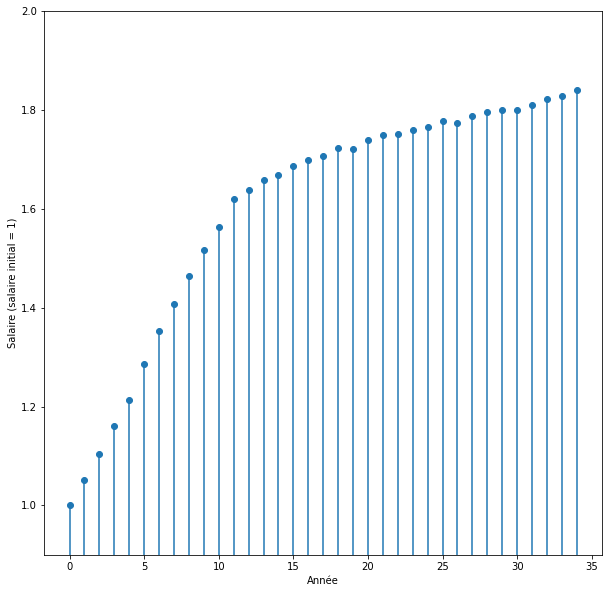

In [72]:
#Etat initial de l'agent

nbr_simu = 200
nbr_annees = 35
S = []

plt.figure(figsize = (10,10))
for k in range(nbr_simu):

    anc_init=0
    i_init = 0 #taux stat
    j_init = 0 #taux excep
    k_init = 0 #revalorisation IM

    tbb = 1
    t_p = Taux_excep[j_init]/100 + Taux_stat[i_init]/100
    s0 = tbb/(1-t_p)
    Sal = [s0/s0]
    state = [(anc_init, i_init, j_init, k_init)]

    for l in range(nbr_annees):
        try:
            liste = P[anc_init][indice(i_init, j_init,k_init),:]
            i, j, k = tirage_al(liste)
        except:
            i, j, k = tirage_al(P[-1][indice(i_init, j_init,k_init),:])
        if k==0:
            anc_init+=1
        else:
            anc_init = 0
        i_init, j_init, k_init = i,j,k
        tbb *=(1+revalo_IM[k]/100)
        t_p = Taux_excep[j]/100 + Taux_stat[i]/100
        s = tbb/(1-t_p)/s0
        Sal.append(s)
        state.append((anc_init,i,j,k))
        S.append(Sal)

S = np.array(S)
S1 =[]
for l in range(nbr_annees):
    S1.append(S[:,l].mean())


plt.stem(S1, use_line_collection=True)
plt.ylabel('Salaire (salaire initial = 1)')
plt.xlabel('Année')
# plt.plot(range(len(S[-1,:])), S[-1,:], c='r')
# plt.plot(range(len(S[-55,:])), S[-55,:], c='b')
plt.ylim(0.9,2);